1. Crie uma MLP genérica para modelo de classificação binária (ou não) implementando forward, backward e loss.
    
    a. É necessário que o usuário possa definir quantas layers e neurônios desejar
    
    b. É necessário que a loss utilizada seja binary cross-entropy (estude um pouco mais sobre esse tópico)
    
    c. É necessário que a rede funcione para diferentes datasets de classificação, considerando que o dado de entrada para o modelo já esteja no formato desejado, como por exemplo número de features, target binário.
    
    d. É necessário que a  função de ativação da layer de output retorne uma probabilidade (entre 0 e 1), então use algo como sigmoid por exemplo.
    
    e. A regra de update dos pesos pode ser feita utilizando a regra básica do gradient descent (weight = weight - learning_rate * gradient)
2. (Opcional - Difícil 1) Crie uma MLP para classificar o dataset MNIST e faça as adaptações necessárias
3. (Opcional - Difícil 2) Crie um otimizador para update dos pesos utilizando o gradient e learning_rate. Como por exemplo, o otimizador Adam.
As informações da aula de hoje estão dentro do repositório de lectures/users/luisa/NN/XOR-zero.ipynb. Se precisarem das informações escritas posso emprestar meus rascunhos.


Defining generic Layer class

In [106]:
import numpy as np
import math

class NetOperation():

  def forward():
    pass

  def backward():
    pass

  def optimize():
    pass

class Layer(NetOperation):
  def __init__(self, n_in: int, n_out: int):
    self.weights = np.random.randn(n_in, n_out)
    self.bias = np.zeros(shape=(1, n_out))

  # z = a1w1 + a2w2 + a3w3 + ... + b
  def forward(self, a):
    self.a = a
    return a.dot(self.weights) + self.bias

  # dgrad = dL / z
  # dL / dwi = dL / dz * dz / dwi
  def backward(self, grad):
    # print(f'Layer backward grad received: {grad}')
    # print(f"self.a: {self.a}")
    self.grad_weights = self.a.T.dot(grad)
    self.grad_bias = np.mean(grad, axis=0)
    # DUVIDA PRIMORDIAL (PRECISO VER ISSO, NÃO ENTENDI MUITO BEM)
    # peguei do código da luiza a ideia
    # print(f'grad: {grad}')
    # print(f'self.weights.T: {self.weights.T}')
    return grad.dot(self.weights.T)

  def optimize(self, learning_rate):
    # print(f'Doing optimization with: {self.grad_weights}')
    self.weights -= self.grad_weights * learning_rate
    self.grad_weights = None

    self.bias -= self.grad_bias * learning_rate
    self.grad_bias = None

class ReLU(NetOperation):
  # a: activation
  # z: weighted sum

  # a = f(z)
  def f(self, z):
    return np.maximum(0, z)
  
  # da / dz
  # a = df(z)
  def df(self, z):
    return np.greater(0, z).astype(int)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  # dgrad = dL / da
  # dL / dz = da / dz * dL / da
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
  
class Sigmoid(NetOperation):
  # a: activation
  # z: weighted sum

  def f(self, z):
    return 1 / (1 + np.exp(-z))
  
  def df(self, z):
    s = self.f(z)
    return s * (1 - s)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
    

In [107]:
from matplotlib import pyplot as plt
# https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c
def BCELoss(prediction, target):
  n = len(target)
  return (1 / n) * np.sum(-target * np.log(prediction) - (1 - target) * np.log(1 - prediction))


def dBCELoss(prediction, target, treshold = 20):
  n = len(target)
  grad = (1 / n) * (- np.minimum(target / prediction, [treshold]) + np.minimum((1 - target) / (1 - prediction), [treshold]))
  return grad

class MLP(NetOperation):
  layers: list[NetOperation]

  def __init__(self, n_features: int, neurons_per_layer: list[int]):
    input_layer = [Layer(n_features, neurons_per_layer[0])]
    hidden_layers = []

    for i in range(len(neurons_per_layer) - 1):
    
      hidden_layers.extend([Sigmoid(), Layer(neurons_per_layer[i], neurons_per_layer[i + 1])])


    self.layers = input_layer + hidden_layers + [Sigmoid()]


  def forward(self, x):
    activation = x

    # print(f"Forward initial activation: {activation}")

    for layer in self.layers:
      # print(f"At layer {layer}")
      activation = layer.forward(activation)
      # print(f"New activation: {activation}")

    return activation
  
  # [Sigmoid(), Layer, ReLU, Layer, ReLU, Layer]
  # propagate error
  def backward(self, grad):
    self.layers.reverse()
    
    for layer in self.layers:
      grad = layer.backward(grad)

    self.layers.reverse()

  def optimize(self, learning_rate):
    for i, layer in enumerate(self.layers):
      # if hasattr(layer, 'weights'):
      #   print(f"Layer {i} weights before optimize:")
      #   print(layer.weights)
      layer.optimize(learning_rate)
      # if hasattr(layer, 'weights'):
      #   print(f"Layer {i} weights after optimize:")
      #   print(layer.weights)

  def train(self, X, Y, learning_rate, batch_size, epochs):
        
    xs = range(epochs)
    losses = []
    for epoch in xs:
      print(f'Epoch {epoch}')
      for i in range(0, len(X), batch_size):
        train_samples = X[i : i + batch_size]
        target_samples = Y[i : i + batch_size]


        predictions = self.forward(train_samples)
        # as vezes o erro retornava nan ou inf
        loss = BCELoss(predictions, target_samples)
        d_bce_loss = dBCELoss(predictions, target_samples)
        if i % 10 == 0:
          print(f'loss: {loss}')  
        self.backward(d_bce_loss)
        self.optimize(learning_rate)


      losses.append(loss)

    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.plot(xs, losses)

Train

Epoch 0
loss: 0.8756419983507099
loss: 0.5773354149062977
loss: 0.3864254637984925
loss: 0.1129303987261714
loss: 0.178844051533029
loss: 0.057468757428799436
loss: 0.06587607437382807
loss: 0.18345180516451715
loss: 0.020331991903276343
loss: 0.17531919841636
loss: 0.09795070450549652
loss: 0.07894653242100201
Epoch 1
loss: 0.1179464610414756
loss: 0.12997433497759564
loss: 0.10137888389367711
loss: 0.01760096697375031
loss: 0.05790764126015513
loss: 0.023883904286540247
loss: 0.02451958866637605
loss: 0.060337537643432304
loss: 0.00627436183469303
loss: 0.10140930403134452
loss: 0.04599396875562022
loss: 0.05316563698502032
Epoch 2
loss: 0.06662759318892814
loss: 0.0791917455579097
loss: 0.06329364690721029
loss: 0.007961482857872891
loss: 0.03447399965176523
loss: 0.014596411407117952
loss: 0.013812078423632995
loss: 0.034309856182936284
loss: 0.002979155694532655
loss: 0.06937513280764723
loss: 0.029090118638799137
loss: 0.04261046824084788
Epoch 3
loss: 0.04667887495749836
loss: 0

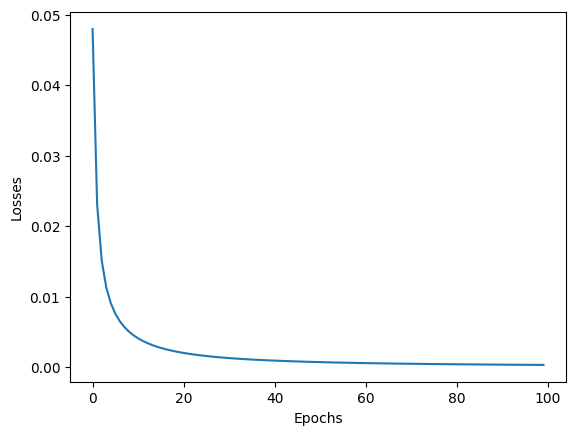

In [108]:
from iris import train

net = MLP(4, [1])
net.train(train['data'], train['target'], learning_rate=0.1, batch_size=2, epochs=100)

Test

In [109]:
from iris import test


predictions = net.forward(test['data'])
BCELoss(predictions, test['target'])

0.0026088532618962486